In [26]:
# CARGAMOS LIBRERIAS

# LIBRERÍAS BÁSICAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import math

# CARGA DE DATOS EN AWS S3
import pyarrow.parquet as pq
import pyarrow as pa
from io import BytesIO
import boto3

# MODELOS DE REDES NEURONALES
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout, Reshape, Conv1D, Masking, LSTM, Conv2D, Input, Multiply, Lambda
from keras.optimizers import Adam
from keras.regularizers import L2, L1L2, L1
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping

# EVALUACIÓN DE MODELOS
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix, precision_score,accuracy_score, recall_score, precision_recall_curve,roc_curve

In [3]:
# CARGAMOS LOS RETORNOS DE TODOS LOS ACTIVOS QUE HAN PERTENECIDO AL IBEX35 Y EL BENCHMARK
returns = pd.read_csv('ibex_historical_returns.csv',index_col='date')
returns.index = pd.to_datetime(returns.index)
returns.head()

,A3TV,ABE,ABG.P,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,...,TRE,TUB,UNF,UNI_1,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-17,NaN,NaN,NaN,NaN,NaN,NaN,0.000831,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.025183,NaN,NaN,NaN,NaN,0.016909
1993-08-18,NaN,NaN,NaN,NaN,NaN,NaN,-0.002079,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.027093,NaN,NaN,NaN,NaN,0.012458
1993-08-19,NaN,NaN,NaN,NaN,NaN,NaN,-0.004088,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.021590,NaN,NaN,NaN,NaN,0.007611
1993-08-20,NaN,NaN,NaN,NaN,NaN,NaN,-0.007048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.005504,NaN,NaN,NaN,NaN,-0.000402
1993-08-23,NaN,NaN,NaN,NaN,NaN,NaN,-0.002867,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,-0.003132


In [4]:
# CARGAMOS LOS DATOS DE PRECIOS DE CIERRE AJUSTADO PARA TODOS LOS ACTIVOS QUE HAN PERTENECIDO AL IBEX35 Y EL BENCHMARK
prices = pd.read_csv('ibex_historical_data.csv', index_col='date')
prices.index = pd.to_datetime(prices.index)
prices.head()

,A3TV,ABE,ABG.P,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,...,TRE,TUB,UNF,UNI_1,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-16,NaN,NaN,NaN,NaN,NaN,NaN,1.2025,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.9683,NaN,NaN,NaN,NaN,3113.896729
1993-08-17,NaN,NaN,NaN,NaN,NaN,NaN,1.2035,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0440,NaN,NaN,NaN,NaN,3166.996826
1993-08-18,NaN,NaN,NaN,NaN,NaN,NaN,1.2010,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.1276,NaN,NaN,NaN,NaN,3206.696777
1993-08-19,NaN,NaN,NaN,NaN,NaN,NaN,1.1961,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0608,NaN,NaN,NaN,NaN,3231.196777
1993-08-20,NaN,NaN,NaN,NaN,NaN,NaN,1.1877,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0440,NaN,NaN,NaN,NaN,3229.896729


In [5]:
def load_risk_free_asset_data(file):
    # CARGAMOS LOS DATOS DE LA TASA DE RETORNO DE LOS BONOS A 3 MESES DE LOS EEUU
    filenames = [filename for filename in os.listdir('./Datos TFM') if filename.startswith(file)]
    risk_free_asset = pd.DataFrame()
    for f in filenames:
        file_path = './Datos TFM/'+f
        file = pd.read_csv(file_path)
        risk_free_asset = pd.concat([risk_free_asset,file], axis=0)
    risk_free_asset.index = pd.to_datetime(risk_free_asset.Date)
    risk_free_asset.sort_index(inplace=True)
    risk_free_asset.drop('Date', axis=1, inplace=True)
    return risk_free_asset

In [6]:
risk_free_asset = load_risk_free_asset_data('Spain 3-Month Bond Yield Historical Data')

In [7]:
def locate_in_df(df, value):
    a = df.to_numpy()
    row = np.where(a == value)[0][0]
    col = np.where(a == value)[1][0]
    return row, col
locate_in_df(returns, returns.min().min()), returns.min().min()

((5135, 37), -1.0195842263237869)

In [8]:
# ELIMINAMOS OUTLIERS EN LOS PRECIOS Y RETORNOS
prices.iloc[5136:,37] = np.nan
returns.iloc[5135:,37] = np.nan
prices.iloc[5626:, 3] = np.nan
returns.iloc[5625:, 3] = np.nan

In [9]:
# DEFINIMOS NUESTRA TASA LIBRE DE RIESGO A TRAVÉS DE LOS VALORES DE LA TASA T-BILLS DE 3 MESES
risk_free_rate = risk_free_asset['Price']/100
risk_free_rate = risk_free_rate.sort_index()
returns['risk_free_rate'] = risk_free_rate.loc[returns.index[0]:]
returns['risk_free_rate'] = returns['risk_free_rate'].fillna(method='ffill')

NECESITAMOS ARMAR UN DATASET CON INFORMACIÓN SOBRE CADA ACCIÓN CADA DIA. NUESTRO PROBLEMA NO SE BASA EN PREDECIR UN SERIE HISTÓRICA, SINO EN CLASIFICAR UN ACTIVO DEPENDIENDO DE SI EN EL ULTIMO PERÍODO ANALIZADO SE ENCUENTRA DENTRO DEL TOP 10 DE ACTIVOS BAJO UN CRITERIO O NO.

PARA ESTO ARMAREMOS UN DATASET PERO SIN IMPORTAR CUAL ES LA POSICIÓN DE CADA ACCIÓN EN SÍ DENTRO DEL RANKING. LO QUE NOS INTERESA SON LOS SIGUIENTES DATOS:
1) MEDIA DE RETORNOS DEL ULTIMO PERIODO A ANALIZAR                          OK
2) SHARPE DEL ULTIMO PERIODO A ANALIZAR                                     OK
3) CANTIDAD DE DIAS EN EL INDICE                                            OK
4) ALFA DE JENSEN DEL ULTIMO PERIODO A ANALIZAR                             OK
5) BETA DEL ULTIMO PERIODO A ANALIZAR                                       OK
6) DESVIACIÓN ESTANDARD DEL ULTIMO PERIODO A ANALIZAR                       OK
7) CANTIDAD DE DIAS EN EL TOP 10
8) MAXIMO DRAWDOWN DEL ULTIMO PERIODO A ANALIZAR                            COMO NO TENEMOS TODO EL HISTORICO DE DATOS DE TODOS LOS ACTIVOS NO ES CONVENIENTE CALCULAR ESTA
                                                                            MEDIDA
9) RATIO DE TREYNOR DEL ULTIMO PERIODO A ANALIZAR                           OK
10) MEDIDA DE MODIGLIANI DEL ULTIMO PERIODO A ANALIZAR                      OK
11) RATIO DE SORTINO DEL ULTIMO PERIODO A ANALIZAR                          OK
12) DISTANCIA CON RESPECTO AL BENCHMARK EN RATIO DE SHARPE                  OK
13) RATIO DE CALMAR DEL ULTIMO PERIODO A ANALIZAR                           COMO NO TENEMOS TODO EL HISTORICO DE DATOS DE TODOS LOS ACTIVOS NO ES CONVENIENTE CALCULAR ESTA
                                                                            MEDIDA
14) MINIMO RETORNO DEL ULTIMO PERIODO A ANALIZAR                            OK
15) MAXIMO RETORNO DEL ULTIMO PERIODO A ANALIZAR                            OK
16) RETORNO ACUMULADO DEL ULTIMO PERIODO A ANALIZAR                         OK
17) RETORNO TOTAL DEL ULTIMO PERIODO A ANALIZAR                             OK
18) RETORNO TOTAL DESDE INGRESO AL INDICE                                   OK
19) MAXIMO DESDE INGRESO AL INDICE                                          OK
20) MINIMO DESDE INGRESO AL INDICE                                          OK
21) DIAS DESDE ULTIMO MAXIMO                                                
22) DIAS DESDE ULTIMO MINIMO
23)                          

NUESTRA ETIQUETA A PREDECIR ES SI EL ACTIVO HA SUPERADO AL BENCHMARK EN ALGUN MOMENTO DEL SIGUIENTE PERÍODO A ANALIZAR. NUESTRO OBJETIVO NO ES PUNTUAR A LOS ACTIVOS DADO QUE LUEGO REALIZAREMOS LA ASIGNACIÓN DE PESOS A TRAVÉS DE MARKOWITZ. NUESTRO OBJETIVO ES SELECCIONAR ACTIVOS DEL TOTAL DE ACTIVOS QUE SE ENCUENTRAN EN EL INDICE:
- 0: NO SE ENCUENTRA EN EL TOP 10.
- 1: SE ENCUENTRA EN EL TOP 10.

DEBEMOS ITERAR PARA TODOS LOS ACTIVOS Y PARA TODOS LOS DIAS COMPLETANDO LA INFORMACIÓN DE NUESTRO DATASET. AL FINAL TENDREMOS UN DATASET CON N + 1 COLUMNAS (SIENDO N LA CANTIDAD DE FEATURES QUE TENEMOS EN NUESTRO DATASET) Y SUMANDO LA ETIQUETA 0 O 1 DEPENDIENDO DE SI ESTUVO EN EL INDICE EN ESE DIA O NO. NUESTRO DATASET FINAL TENDRÁ M FILAS SIENDO M LA CANTIDAD DE DIAS QUE HA COTIZADO CADA ACTIVO RESTANDO LA CANTIDAD DE PERIODOS QUE SE TOMEN PARA HACER EL PRIMER ANALISIS MULTIPLICADO POR LA CANTIDAD DE ACTIVOS. PARA LA ENTRADA A LA RED NO ES NECESARIO CONOCER QUÉ ACCIÓN ESTAMOS SELECCIONANDO DADO QUE LO QUE NOS IMPORTAN SON SUS CARACTERISTICAS EN EL DIA ANALIZADO. LO QUE SE BUSCA ES ENTONCES DADA UNA SERIE DE CARACTERISTICAS, ETIQUETAR UNA ACCIÓN. LUEGO SE TOMARÁN LOS RECAUDOS NECESARIOS PARA ENTENDER QUÉ ACCIÓN ES Y EN QUÉ MOMENTO. NUESTRO ANALISIS BUSCA TOMAR UNA DECISIÓN A DIA DE HOY BASANDONOS EN INFORMACIÓN HISTÓRICA. NO BUSCA PREDECIR LA BOLSA NI ANALIZAR QUE PASARÁ DE AQUI EN EL FUTURO.

In [114]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv, pinv
from scipy.optimize import minimize
import pandas as pd

In [115]:
def getIVP(cov,**kargs): 
    # Compute the inverse-variance portfolio 
    ivp=1./np.diag(cov)
    ivp/=ivp.sum() 
    return ivp 
#------------------------------------------------------------------------------ 
def getClusterVar(cov,cItems): 
    # Compute variance per cluster 
    cov_=cov.loc[cItems,cItems]
    # matrix slice 
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar 
#------------------------------------------------------------------------------
def getQuasiDiag(link): 
    # Sort clustered items by distance 
    link=link.astype(int) 
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] 
    # number of original items 
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1 
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2 
        sortIx=sortIx.sort_index() # re-sort
        sortIx.index=range(sortIx.shape[0])
        # re-index 
        
    return sortIx.tolist()
    
def getRecBipart(cov,sortIx):
    # Compute HRP alloc 
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster 
    while len(cItems)>0: 
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)//2),(len(i)//2,len(i))) if len(i)>1] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0=cItems[i] # cluster 1 
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0) 
            cVar1=getClusterVar(cov,cItems1) 
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1 
            w[cItems1]*=1-alpha # weight 2 
    return w

def correlDist(corr): # A distance matrix based on correlation, where 0<=d[i,j]<=1 # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist 

def hierarchical_risk_parity(data,last_date,alpha,corr,cov):
    activos = data.dropna().index[:-1]
    alpha_activos = alpha.loc[last_date,activos].sort_values(ascending=False)
    selected_assets = alpha_activos[alpha_activos>0].index
    corr = corr.loc[last_date][selected_assets].T[selected_assets]
    cov = cov.loc[last_date][selected_assets].T[selected_assets]
    dist = correlDist(corr) 
    link = sch.linkage(dist.dropna(),'single') 
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist() # recover labels 
    df0 = corr.loc[sortIx,sortIx] # reorder 
    hrp = getRecBipart(cov,sortIx) 
    return hrp

ValueError: shapes (1,10) and (99,99) not aligned: 10 (dim 1) != 99 (dim 0)

In [38]:
# REALIZAMOS LA GENERACIÓN DE CARACTERISTICAS PARA UNA SOLA ACCIÓN PARA UN SOLO DÍA. ASÍ COMO TAMBIEN TRAERSE LOS DATOS DEL BENCHMARK Y LA TASA LIBRE DE RIESGO
# PRIMERO TOMAMOS LOS RETORNOS DIARIOS AL CIERRE DEL PRIMER PERIODO A SELECCIONAR. TOMAMOS COMO PERIODO 30 DÍAS.
DIAS = 30
VAR_LIMIT = 0.05

In [39]:
dataset = pd.DataFrame()

for c in range(0, returns.shape[1] - 2):

    period_data = returns.iloc[:,[c,-2,-1]].dropna()
    stock_prices = prices.iloc[1:,c].dropna()
    returns_act = period_data.iloc[:,0]
    returns_risk_free_rate = period_data.iloc[:,-1]
    returns_benchmark = period_data.iloc[:,-2]

    for i in range(period_data.shape[0] - DIAS):
        # OBTENEMOS EL NOMBRE DEL ACTIVO
        stock_name = returns_act.name
        
        # OBTENEMOS LOS RETORNOS DEL PERIODO ANTERIOR
        previous_period_act = returns_act[i:DIAS+i]

        # CALCULAMOS LOS RETORNOS TOTALES, RETORNOS ACUMULADOS, RETORNOS DESDE SU ENTRADA AL INDICE
        previous_period_total_returns = returns_act[DIAS+i] - returns_act[i]
        previous_period_cumulative_returns = returns_act[i:DIAS+i].sum()
        total_act_cumulative_returns = returns_act[:DIAS+i].sum()
        total_act_returns = returns_act[DIAS+i] - returns_act[0]
        # CALCULAMOS LA MEDIA Y LA DESVIACIÓN ESTANDARD DE ESE PERIODO
        previous_period_mean_returns = previous_period_act.mean()
        previous_period_std_returns = previous_period_act.std()

        # CALCULAMOS LOS RETORNOS MAXIMOS Y MINIMOS DEL PERIODO
        previous_period_max_returns = previous_period_act.max()
        previous_period_min_returns = previous_period_act.min()

        # OBTENEMOS LOS DIAS QUE ESTUVO EN EL INDICE HASTA EL MOMENTO
        days_in_index = DIAS + i

        # OBTENEMOS EL DIA DE ANALISIS
        date = previous_period_act.index[-1]
        
        # CALCULAMOS EL MAXIMO Y EL MINIMO DESDE LA SALIDA AL INDICE
        total_act_max_price = stock_prices[:DIAS+i].max()
        total_act_min_price = stock_prices[:DIAS+i].min()

        days_since_last_max = (stock_prices.index[DIAS+i] - stock_prices[:DIAS+i].loc[stock_prices==total_act_max_price].index).days.values[0]
        days_since_last_min = (stock_prices.index[DIAS+i] - stock_prices[:DIAS+i].loc[stock_prices==total_act_min_price].index).days.values[0]

        daily_drawdown = (stock_prices[:DIAS+i] / total_act_max_price) - 1
        max_drawdown = daily_drawdown.min()

        # PARA CALCULAR EL RATIO DE SHARPE DEBEMOS OBTENER LOS DATOS DE LA TASA LIBRE DE RIESGO PARA ESE DIA Y DIVIDIR EL RETORNO MEDIO AJUSTADO POR LA TASA LIBRE DE RIESGO
        # POR LA DESVIACIÓN ESTANDAR DE LOS RETORNOS.
        period_risk_free_rate = returns_risk_free_rate.iloc[DIAS+i]

        # CALCULAMOS EL RATIO DE SHARPE PARA ESTE PERIODO
        period_sharpe_ratio = (previous_period_mean_returns - period_risk_free_rate) / previous_period_std_returns

        # CALCULAMOS EL RATIO DE CALMAR
        calmar_ratio = (previous_period_mean_returns - period_risk_free_rate) / max_drawdown

        # CALCULAMOS EL VALUE AT RISK Y EL EXPECTED SHORTFALL
        value_at_risk = previous_period_act.quantile(q=VAR_LIMIT)
        expected_shortfall = previous_period_act[previous_period_act<value_at_risk].mean()

        # CALCULAMOS LA 
        downside_dev  = np.minimum(1e-9, previous_period_act - period_risk_free_rate) ** 2
        downside_dev = np.sqrt(downside_dev.mean())

        # CALCULAMOS EL RATIO DE SORTINO
        period_sortino_ratio =  (previous_period_mean_returns - period_risk_free_rate) / downside_dev

        # CALCULAMOS LA MEDIA Y DESVIACION ESTANDAR DE LOS RETORNOS DEL BENCHMARK
        previous_period_benchmark = returns_benchmark[i:DIAS+i]
        total_benchmark_returns = returns_benchmark[DIAS+i] - returns_benchmark[0]
        previous_period_total_returns_benchmark = returns_benchmark[DIAS+i] - returns_benchmark[i]
        previous_period_mean_returns_benchmark = previous_period_benchmark.mean()
        previous_period_std_returns_benchmark = previous_period_benchmark.std()

        # CALCULAMOS LA BETA DEL ACTIVO CON RESPECTO AL BENCHMARK
        market_stock_cov = np.cov(previous_period_act, previous_period_benchmark)
        beta = (market_stock_cov[0, 1]/market_stock_cov[1, 1])

        # CALCULAMOS EL RATO DE TREYNOR
        treynor_ratio = previous_period_mean_returns / beta

        # AJUSTAMOS LOS RETORNOS DEL ACTIVO POR LOS RETORNOS DEL BENCHMARK
        benchmark_adjusted_returns = (previous_period_act - previous_period_benchmark)
        benchmark_adjusted_returns_mean = benchmark_adjusted_returns.mean()
        benchmark_adjusted_returns_std = benchmark_adjusted_returns.std()

        # CALCULAMOS LA DISTANCIA MEDIA AL BENCHMARK
        benchmark_distance = np.sqrt(np.mean((previous_period_benchmark - previous_period_act)**2))

        # CALCULAMOS EL INFORMATION RATIO
        information_ratio = benchmark_adjusted_returns_mean / benchmark_adjusted_returns_std

        # CALCULAMOS LA MEDIDA DE MODIGLIANI
        modigliani_measure = ((period_sharpe_ratio * previous_period_std_returns_benchmark) + period_risk_free_rate)

        # CALCULAMOS EL ALFA DE JENSEN
        period_alfa_jensen = previous_period_total_returns - (period_risk_free_rate - beta * (previous_period_total_returns_benchmark - period_risk_free_rate))

        data_period_stock = {
            'ticker': stock_name,
            'date': date,
            'days_in_index': days_in_index,
            'period_total_return': previous_period_total_returns,
            'calmar_ratio': calmar_ratio,
            'max_drawdown': max_drawdown,
            'period_cumulative_return': previous_period_cumulative_returns,
            'total_cumulative_return': total_act_cumulative_returns,
            'days_since_last_max': days_since_last_max,
            'days_since_last_min': days_since_last_min,
            'value_at_risk': value_at_risk,
            'expected_shortfall': expected_shortfall,
            'period_mean_return': previous_period_mean_returns,
            'period_std_return': previous_period_std_returns,
            'period_min_return': previous_period_min_returns,
            'period_max_return': previous_period_max_returns,
            'sharpe_ratio': period_sharpe_ratio,
            'sortino_ratio': period_sortino_ratio,
            'beta': beta,
            'treynor_ratio': treynor_ratio,
            'benchmark_distance': benchmark_distance,
            'information_ratio': information_ratio,
            'modigliani_measure': modigliani_measure,
            'alfa_jensen': period_alfa_jensen
        }

        data_period_stock = pd.DataFrame([data_period_stock])
        dataset = pd.concat([dataset, data_period_stock], axis=0)
    print(stock_name)

A3TV
ABE
ABG.P
ABG.P_1
ABG
ACS
ACX_1
ACX_2
AENA
AGS
ALB_2
ALB_3
ALM
ALT
AMP
AMS_1
ANA_1
ANA_2
ANE
BBVA
BKIA
BKIA_1
BKT
BME
BTO_1
BTO_2
CABK
CIE
CIN
CLNX
COL
COL_1
CRI_2
DIA
DRC
EBRO
EBRO_1
ELE
ELE_1
ENC
ENC_1
ENG
EVA
FAD
FCC
FDR
FER
GAM
GAM_1
GRF
IAG
IBE
IBLA
IBR
IDR
ITX
JAZ
LOG
LOR
MAP
MAP_1
MAP_2
MAS
MEL
MRL
MTS
NHH
NHH_2
NTGY
OHLA
PHM
POP
PRS
PRS_1
PUL
RED
REE
REE_1
REP
ROVI
SAB
SAN
SAN_1
SCYR
SCYR_1
SCYR_2
SGC
SGRE
SLR
SOL
TEF
TEM
TL5
TRE
TUB
UNF
UNI_1
VIS
VIS_1
VIS_2
VIS_3
ZEL


In [41]:
# dataset = dataset[~dataset['ticker'].isin(['risk_free_rate','benchmark'])]
dataset.reset_index(drop=True, inplace=True)

In [42]:
dataset.fillna(0, inplace=True)

In [43]:
act_list = dataset['ticker'].unique()
act_list

array(['A3TV', 'ABE', 'ABG.P', 'ABG.P_1', 'ABG', 'ACS', 'ACX_1', 'ACX_2',
       'AENA', 'AGS', 'ALB_2', 'ALB_3', 'ALM', 'ALT', 'AMP', 'AMS_1',
       'ANA_1', 'ANA_2', 'ANE', 'BBVA', 'BKIA', 'BKIA_1', 'BKT', 'BME',
       'BTO_1', 'BTO_2', 'CABK', 'CIE', 'CIN', 'CLNX', 'COL', 'COL_1',
       'CRI_2', 'DIA', 'DRC', 'EBRO', 'EBRO_1', 'ELE', 'ELE_1', 'ENC',
       'ENC_1', 'ENG', 'EVA', 'FAD', 'FCC', 'FDR', 'FER', 'GAM', 'GAM_1',
       'GRF', 'IAG', 'IBE', 'IBLA', 'IBR', 'IDR', 'ITX', 'JAZ', 'LOG',
       'LOR', 'MAP', 'MAP_1', 'MAP_2', 'MAS', 'MEL', 'MRL', 'MTS', 'NHH',
       'NHH_2', 'NTGY', 'OHLA', 'PHM', 'POP', 'PRS', 'PRS_1', 'PUL',
       'RED', 'REE', 'REE_1', 'REP', 'ROVI', 'SAB', 'SAN', 'SAN_1',
       'SCYR', 'SCYR_1', 'SCYR_2', 'SGC', 'SGRE', 'SLR', 'SOL', 'TEF',
       'TEM', 'TL5', 'TRE', 'TUB', 'UNF', 'UNI_1', 'VIS', 'VIS_1',
       'VIS_2', 'VIS_3', 'ZEL'], dtype=object)

In [44]:
for act in act_list:
    index = dataset[(dataset['ticker'] == act)].index
    dataset.loc[index, 'sharpe_ratio_next_period'] = dataset.loc[index,'sharpe_ratio'].shift(-30)
    dataset.loc[index, 'returns_next_period'] = dataset.loc[index,'period_total_return'].shift(-30)
    dataset.loc[index, 'alfa_next_period'] = dataset.loc[index,'alfa_jensen'].shift(-30)


In [213]:
indexes = dataset[dataset['alfa_jensen']>0].index
dataset.loc[indexes,'alfa_signal'] = 1
dataset.loc[~dataset.index.isin(indexes),'alfa_signal'] = 0

In [212]:
dataset.drop('label', axis=1, inplace=True)

In [214]:
for t in dataset['ticker'].unique():
    ticker_data = dataset[dataset['ticker']==t]
    alfa_ticker_data = ticker_data['alfa_signal'].iloc[::-1].rolling(30).sum()
    alfa_ticker_data_index = alfa_ticker_data[alfa_ticker_data > 0].index
    dataset.loc[alfa_ticker_data_index,'label'] = 1

In [215]:
dataset['label'].fillna(0, inplace=True)

In [216]:
dataset_2 = dataset.copy().dropna(axis=0)
dataset_2.head()

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,days_since_last_max,days_since_last_min,...,treynor_ratio,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen,sharpe_ratio_next_period,returns_next_period,alfa_next_period,alfa_signal,label
0,A3TV,2005-08-19,30,0.013208,0.928893,-0.095061,-0.084034,-0.084034,31,2,...,-0.005267,0.011935,-0.343632,0.049597,-0.120066,-8.598475,0.000000,-0.109859,0.0,0.0
1,A3TV,2005-08-22,31,0.008768,0.924262,-0.095061,-0.070826,-0.084034,34,5,...,-0.003285,0.011286,-0.305949,0.050582,-0.142976,-8.598475,0.002218,-0.105099,0.0,0.0
2,A3TV,2005-08-23,32,-0.002416,0.921187,-0.095061,-0.062058,-0.080980,35,6,...,-0.003553,0.011391,-0.252988,0.049042,-0.142941,-8.556868,0.008163,-0.110448,0.0,0.0
3,A3TV,2005-08-24,33,-0.041096,0.922035,-0.095061,-0.064474,-0.089144,36,7,...,-0.003209,0.011217,-0.236099,0.049823,-0.192086,-8.603079,0.019626,-0.089563,0.0,0.0
4,A3TV,2005-08-25,34,0.016930,0.936445,-0.095061,-0.105571,-0.114041,37,8,...,-0.004284,0.011298,-0.328375,0.047374,-0.143515,-9.518182,-0.038972,-0.130236,0.0,0.0


In [217]:
# # ITERAMOS PARA TODAS LAS FECHAS CON EL OBJETIVO DE ETIQUETAR LOS DATOS
# # NUESTRO CRITERIO SE BASARÁ EN EL RATIO DE SHARPE. AQUELLOS ACTIVOS QUE ESTÉN EN EL TOP 10 DE RATIO DE SHARPE PARA CADA FECHA SE LOS ETIQUETARÁ CON UN 1, MIENTRAS
# # QUE AQUELLOS QUE SE ENCUENTREN FUERA DEL TOP 10 PARA CADA FECHA SE LOS ETIQUETARÁ CON UN 0
# for i in range(dataset_2.shape[0]):
#     if dataset_2.loc[i,'alfa_next_period'] > 0:
#         dataset_2.loc[i,'label'] = 1
#     else:
#         dataset_2.loc[i,'label'] = 0
#     print(dataset_2.loc[i,'label'])

In [218]:
# dataset_2['days_in_top'] = 0
# for t in dataset_2['ticker'].unique():
#     dataset_2[dataset['ticker']==t]

In [219]:
dataset_2.dropna(axis=0, inplace=True)

In [11]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

s3_client = boto3.client('s3')
s3 = boto3.resource('s3')

In [12]:
bucket_name = 'stock-market-historical-data'
table = pa.Table.from_pandas(dataset_2)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, 'categorical_dataset').put(Body=buf.getvalue())

NameError: name 'dataset_2' is not defined

In [13]:
bucket_name = 'stock-market-historical-data'
processed_folder = 'processed/marketstack/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

In [14]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [15]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
file_name = 'categorical_dataset'
dataset = pd.DataFrame(pq.read_table(download_s3_parquet_file(s3, bucket_name,file_name)).to_pandas())
dataset.head()

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,days_since_last_max,days_since_last_min,...,treynor_ratio,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen,sharpe_ratio_next_period,returns_next_period,alfa_next_period,alfa_signal,label
0,A3TV,2005-08-19,30,0.013208,0.928893,-0.095061,-0.084034,-0.084034,31,2,...,-0.005267,0.011935,-0.343632,0.049597,-0.120066,-8.598475,0.000000,-0.109859,0.0,0.0
1,A3TV,2005-08-22,31,0.008768,0.924262,-0.095061,-0.070826,-0.084034,34,5,...,-0.003285,0.011286,-0.305949,0.050582,-0.142976,-8.598475,0.002218,-0.105099,0.0,0.0
2,A3TV,2005-08-23,32,-0.002416,0.921187,-0.095061,-0.062058,-0.080980,35,6,...,-0.003553,0.011391,-0.252988,0.049042,-0.142941,-8.556868,0.008163,-0.110448,0.0,0.0
3,A3TV,2005-08-24,33,-0.041096,0.922035,-0.095061,-0.064474,-0.089144,36,7,...,-0.003209,0.011217,-0.236099,0.049823,-0.192086,-8.603079,0.019626,-0.089563,0.0,0.0
4,A3TV,2005-08-25,34,0.016930,0.936445,-0.095061,-0.105571,-0.114041,37,8,...,-0.004284,0.011298,-0.328375,0.047374,-0.143515,-9.518182,-0.038972,-0.130236,0.0,0.0


In [16]:
dataset_2 = dataset.copy()

In [17]:
x_axis_labels = np.sort(dataset_2['label'].unique().astype(int).astype(str))
label_count = dataset_2['label'].value_counts()
legend_label = ['Stocks with negative alpha', 'Stocks with positive alpha']

In [18]:
label_count

label
1.0    115081
0.0     92201
Name: count, dtype: int64

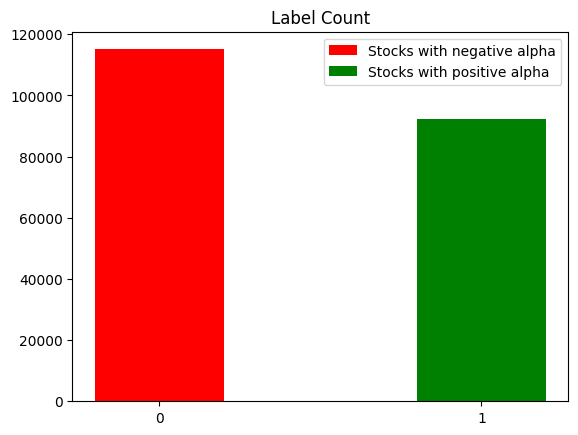

In [19]:
plt.bar(x_axis_labels, label_count, width=0.4, label=legend_label, color=['red','green'])
plt.title('Label Count')
plt.legend(loc='upper right');
plt.savefig('label_imbalance.png', dpi=300, format='png')

In [20]:
dataset_2.value_counts(['ticker','label'])

ticker  label
IBE     0.0      4199
TEF     0.0      4174
REP     0.0      4159
FCC     0.0      4138
ACX_1   0.0      4125
                 ... 
DIA     0.0        29
ENC_1   0.0        29
ALM     0.0        29
MAS     0.0        29
BKIA_1  0.0        29
Name: count, Length: 190, dtype: int64

In [21]:
dataset_2.sort_values('date', inplace=True)

In [27]:
train_val_dataset = dataset_2[dataset['date'] < '2021-01-01'].drop(['ticker','date','sharpe_ratio_next_period', 'returns_next_period', 'alfa_next_period','alfa_signal'],axis=1)
dataset_test = dataset_2[dataset['date'] >= '2021-01-01'].drop(['ticker','date','sharpe_ratio_next_period', 'returns_next_period', 'alfa_next_period','alfa_signal'],axis=1)
train_val_dataset.shape, dataset_test.shape

C:\Users\aleja\AppData\Local\Temp\ipykernel_16436\3786310647.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_val_dataset = dataset_2[dataset['date'] < '2021-01-01'].drop(['ticker','date','sharpe_ratio_next_period', 'returns_next_period', 'alfa_next_period','alfa_signal'],axis=1)
C:\Users\aleja\AppData\Local\Temp\ipykernel_16436\3786310647.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_test = dataset_2[dataset['date'] >= '2021-01-01'].drop(['ticker','date','sharpe_ratio_next_period', 'returns_next_period', 'alfa_next_period','alfa_signal'],axis=1)


((184964, 23), (22318, 23))

In [28]:
def dataset_split(train_dataset, test_dataset, val_split=0.8, training_mode='single',scaling=True):

    if training_mode == 'single':
        val_split = math.floor(train_dataset.shape[0] * val_split)
        train = train_dataset.iloc[:val_split]
        val = train_dataset.iloc[val_split:]
        train = shuffle(train)
        val = shuffle(val)
        test = shuffle(test_dataset)

        X_train = train.iloc[:,:-1]
        X_val = val.iloc[:,:-1]
        X_test = test.iloc[:,:-1]
        y_train = train.iloc[:,-1]
        y_val = val.iloc[:,-1]
        y_test = test.iloc[:,-1]
        
        if scaling:
            try:
                scaler = StandardScaler()
            except:
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()

            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)

        return X_train, X_val, X_test, y_train, y_val, y_test

    elif training_mode == 'cross_val':
        train = shuffle(train_dataset)
        test = shuffle(test_dataset)
        
        X_train = train.iloc[:,:-1]
        X_test = test.iloc[:,:-1]
        y_train = train.iloc[:,-1]
        y_test = test.iloc[:,-1]

        if scaling:
            try:
                scaler = StandardScaler()
            except:
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        return X_train, X_test, y_train, y_test

In [29]:
X_train, X_val, X_test, y_train, y_val, y_test = dataset_split(train_val_dataset, dataset_test, 0.8,'single',True)
# X_train, X_test, y_train, y_test = dataset_split(train_val_dataset, dataset_test, 0.8,'cross_val')

In [236]:
from sklearn.linear_model import LogisticRegression

In [264]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_logr = clf.predict(X_test)
y_pred_logr_probas = clf.predict_proba(X_test)

In [258]:
import seaborn as sns

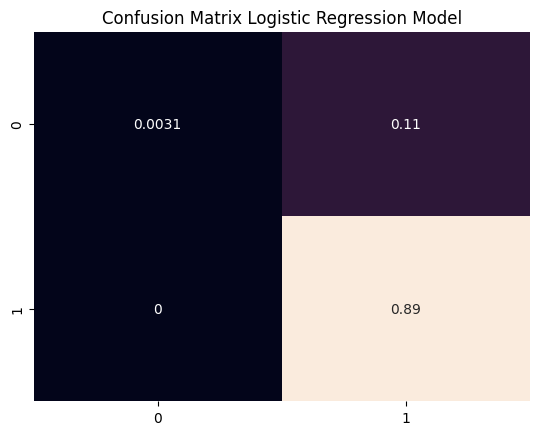

In [263]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_logr, normalize='all'), index = [0, 1],
                  columns = [0, 1])

sns.heatmap(df_cm, annot=True,cbar=False)
plt.title('Confusion Matrix Logistic Regression Model');

In [273]:
auc = roc_auc_score(y_test, y_pred_logr_probas[:,1])
kappa = cohen_kappa_score(y_test, y_pred_logr)
accuracy = accuracy_score(y_test, y_pred_logr)

In [275]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_logr_probas[:,1])

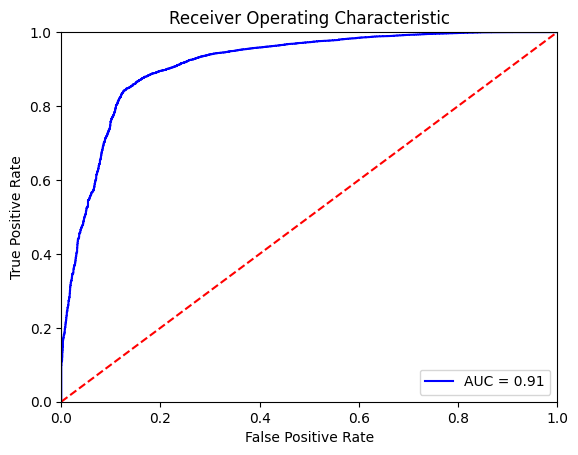

In [276]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


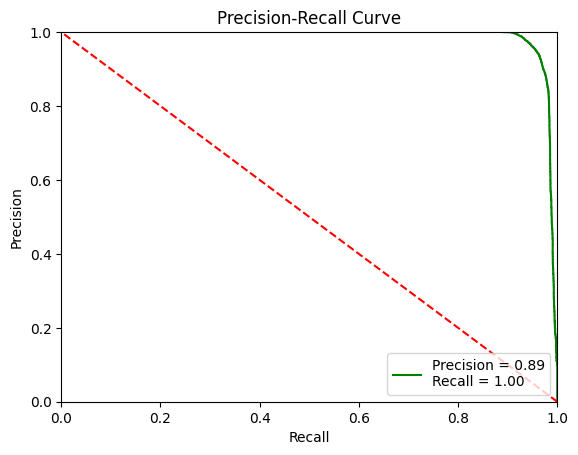

In [277]:
precision, recall,thres = precision_recall_curve(y_test, y_pred_logr_probas[:,1])
prec = precision_score(y_test, y_pred_logr)
rec = recall_score(y_test, y_pred_logr)
plt.title('Precision-Recall Curve')
plt.plot(precision, recall, 'g', label = 'Precision = %0.2f\nRecall = %0.2f' % (prec, rec))
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall');

In [244]:
from sklearn.inspection import permutation_importance
perm = permutation_importance(clf, X_val, y_val.astype(int), scoring='accuracy', n_repeats=10, random_state=42, n_jobs=2)

In [295]:
perm

{'importances_mean': array([ 4.96310113e-03,  3.50606872e-03,  0.00000000e+00, -8.10964236e-06,
        -2.70321412e-05, -2.43289271e-05, -8.10964236e-06,  2.28962236e-03,
        -8.10964236e-06,  1.25969778e-03, -2.70321412e-05,  2.92217447e-03,
        -1.21644635e-04, -2.70321412e-05, -1.62192847e-05,  3.75746763e-04,
         0.00000000e+00,  0.00000000e+00,  1.30294921e-03, -2.16257130e-05,
        -1.62192847e-05,  3.01408375e-03]),
 'importances_std': array([2.29439031e-04, 1.29105008e-04, 0.00000000e+00, 1.23876833e-05,
        0.00000000e+00, 8.10964236e-06, 1.23876833e-05, 2.57032880e-04,
        1.23876833e-05, 7.47183249e-05, 0.00000000e+00, 1.35942378e-04,
        6.07471820e-05, 0.00000000e+00, 1.32429905e-05, 8.10964236e-06,
        0.00000000e+00, 0.00000000e+00, 1.20770459e-04, 1.08128565e-05,
        1.32429905e-05, 1.01325466e-04]),
 'importances': array([[ 4.62249615e-03,  4.83875328e-03,  4.64952829e-03,
          4.78468900e-03,  5.29829968e-03,  4.94688184e-03,


In [294]:
feature_importances = pd.Series(perm.importances_mean.sort_values(ascending=False), index=train_val_dataset.iloc[:,:-1].columns)

fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=perm.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

In [278]:
selected_features = feature_importances[feature_importances > 0]
selected_features

days_in_index          0.004963
period_total_return    0.003506
days_since_last_min    0.002290
expected_shortfall     0.001260
period_std_return      0.002922
sortino_ratio          0.000376
benchmark_distance     0.001303
alfa_jensen            0.003014
dtype: float64

In [281]:
def create_model():
    input = Input(shape=(X_train_scaled.shape[1],))
    
    layer_1 = Dense(12, activation='relu', kernel_regularizer=L2(0.0001))(input)
    dropout_1 = Dropout(0.1)(layer_1)
    layer_2 = Dense(6, activation='relu', kernel_regularizer=L2(0.0001))(dropout_1)
    dropout_2 = Dropout(0.1)(layer_2)
    layer_3 = Dense(3, activation='relu', kernel_regularizer=L2(0.0001))(dropout_2)
    dropout_3 = Dropout(0.1)(layer_3)
    flatten = Flatten()(dropout_3)

    output = Dense(1, activation='sigmoid')(flatten)

    model = Model(inputs=input, outputs=output)

    model.summary()

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
    tf.keras.utils.plot_model(
        model,
        to_file="fixed_model.png",
        show_shapes=True,
        dpi=300)
    return model

In [30]:
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    # mode='min',
    restore_best_weights=True
    )

In [284]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate

In [285]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=1, callbacks = [earlystopping], validation_split=0.2)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {'acc': 'accuracy',
           'mse': 'neg_mean_squared_error'}
results = cross_validate(model, X_train, y_train, scoring=scoring, cv=kfold, return_train_score=True)


c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense_32 (Dense)            (None, 12)                276       
                                                                 
 dropout_24 (Dropout)        (None, 12)                0         
                                                                 
 dense_33 (Dense)            (None, 6)                 78        
                                                                 
 dropout_25 (Dropout)        (None, 6)                 0         
                                                                 
 dense_34 (Dense)            (None, 3)                 21        
                                                                 
 dropout_26 (Dropout)        (None, 3)                 0   

c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
3330/3330 [==============================] - 9s 2ms/step - loss: 0.5108 - accuracy: 0.7646 - val_loss: 0.2291 - val_accuracy: 0.9457
Epoch 2/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2410 - accuracy: 0.9040 - val_loss: 0.1568 - val_accuracy: 0.9553
Epoch 3/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2095 - accuracy: 0.9123 - val_loss: 0.1465 - val_accuracy: 0.9579
Epoch 4/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1988 - accuracy: 0.9142 - val_loss: 0.1417 - val_accuracy: 0.9585
Epoch 5/100
3330/3330 [==============================] - 8s 3ms/step - loss: 0.1949 - accuracy: 0.9408 - val_loss: 0.1386 - val_accuracy: 0.9594
Epoch 6/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1879 - accuracy: 0.9460 - val_loss: 0.1366 - val_accuracy: 0.9603
Epoch 7/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1868 - accuracy: 0.9467 - val_loss: 0.1352 - val_ac

c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3330/3330 [==============================] - 9s 2ms/step - loss: 0.4977 - accuracy: 0.7856 - val_loss: 0.2641 - val_accuracy: 0.9448
Epoch 2/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2422 - accuracy: 0.9312 - val_loss: 0.1627 - val_accuracy: 0.9525
Epoch 3/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2051 - accuracy: 0.9408 - val_loss: 0.1500 - val_accuracy: 0.9559
Epoch 4/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1951 - accuracy: 0.9442 - val_loss: 0.1444 - val_accuracy: 0.9582
Epoch 5/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1883 - accuracy: 0.9461 - val_loss: 0.1411 - val_accuracy: 0.9591
Epoch 6/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1843 - accuracy: 0.9470 - val_loss: 0.1392 - val_accuracy: 0.9592
Epoch 7/100
3330/3330 [==============================] - 8s 3ms/step - loss: 0.1816 - accuracy: 0.9482 - val_loss: 0.1375 - val_accuracy: 0.95

c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
3330/3330 [==============================] - 9s 2ms/step - loss: 0.5277 - accuracy: 0.7819 - val_loss: 0.2306 - val_accuracy: 0.9472
Epoch 2/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2372 - accuracy: 0.9106 - val_loss: 0.1515 - val_accuracy: 0.9568
Epoch 3/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2136 - accuracy: 0.9175 - val_loss: 0.1434 - val_accuracy: 0.9595
Epoch 4/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1974 - accuracy: 0.9189 - val_loss: 0.1410 - val_accuracy: 0.9603
Epoch 5/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1918 - accuracy: 0.9205 - val_loss: 0.1394 - val_accuracy: 0.9603
Epoch 6/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1898 - accuracy: 0.9210 - val_loss: 0.1379 - val_accuracy: 0.9611
Epoch 7/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1863 - accuracy: 0.9204 - val_loss: 0.1367 - val_ac

c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
3330/3330 [==============================] - 9s 2ms/step - loss: 0.4111 - accuracy: 0.8092 - val_loss: 0.1907 - val_accuracy: 0.9467
Epoch 2/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2552 - accuracy: 0.8953 - val_loss: 0.1540 - val_accuracy: 0.9539
Epoch 3/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2229 - accuracy: 0.9261 - val_loss: 0.1463 - val_accuracy: 0.9580
Epoch 4/100
3330/3330 [==============================] - 9s 3ms/step - loss: 0.2024 - accuracy: 0.9436 - val_loss: 0.1421 - val_accuracy: 0.9598
Epoch 5/100
3330/3330 [==============================] - 9s 3ms/step - loss: 0.1957 - accuracy: 0.9456 - val_loss: 0.1395 - val_accuracy: 0.9603
Epoch 6/100
3330/3330 [==============================] - 9s 3ms/step - loss: 0.1879 - accuracy: 0.9469 - val_loss: 0.1377 - val_accuracy: 0.9609
Epoch 7/100
3330/3330 [==============================] - 9s 3ms/step - loss: 0.1881 - accuracy: 0.9464 - val_loss: 0.1368 - val_ac

c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 22)]              0         
                                                                 
 dense_52 (Dense)            (None, 12)                276       
                                                                 
 dropout_39 (Dropout)        (None, 12)                0         
                                                                 
 dense_53 (Dense)            (None, 6)                 78        
                                                                 
 dropout_40 (Dropout)        (None, 6)                 0         
                                                                 
 dense_54 (Dense)            (None, 3)                 21        
                                                                 
 dropout_41 (Dropout)        (None, 3)                 0  

c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 22)]              0         
                                                                 
 dense_56 (Dense)            (None, 12)                276       
                                                                 
 dropout_42 (Dropout)        (None, 12)                0         
                                                                 
 dense_57 (Dense)            (None, 6)                 78        
                                                                 
 dropout_43 (Dropout)        (None, 6)                 0         
                                                                 
 dense_58 (Dense)            (None, 3)                 21        
                                                                 
 dropout_44 (Dropout)        (None, 3)                 0         
          

c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
3330/3330 [==============================] - 9s 2ms/step - loss: 0.5412 - accuracy: 0.7863 - val_loss: 0.3960 - val_accuracy: 0.9446
Epoch 2/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.3144 - accuracy: 0.9270 - val_loss: 0.1715 - val_accuracy: 0.9549
Epoch 3/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2090 - accuracy: 0.9396 - val_loss: 0.1490 - val_accuracy: 0.9582
Epoch 4/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1935 - accuracy: 0.9449 - val_loss: 0.1448 - val_accuracy: 0.9594
Epoch 5/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1847 - accuracy: 0.9477 - val_loss: 0.1416 - val_accuracy: 0.9603
Epoch 6/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1790 - accuracy: 0.9491 - val_loss: 0.1391 - val_accuracy: 0.9612
Epoch 7/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1755 - accuracy: 0.9505 - val_loss: 0.1383 - val_ac

c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
3330/3330 [==============================] - 10s 3ms/step - loss: 0.4701 - accuracy: 0.8053 - val_loss: 0.2221 - val_accuracy: 0.9468
Epoch 2/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2387 - accuracy: 0.9318 - val_loss: 0.1572 - val_accuracy: 0.9544
Epoch 3/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2046 - accuracy: 0.9423 - val_loss: 0.1467 - val_accuracy: 0.9572
Epoch 4/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1971 - accuracy: 0.9456 - val_loss: 0.1430 - val_accuracy: 0.9575
Epoch 5/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1916 - accuracy: 0.9466 - val_loss: 0.1408 - val_accuracy: 0.9578
Epoch 6/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1873 - accuracy: 0.9490 - val_loss: 0.1395 - val_accuracy: 0.9581
Epoch 7/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1849 - accuracy: 0.9496 - val_loss: 0.1384 - val_a

c:\Users\aleja\Documents\GitHub\TFM-Algoritmo-con-redes-evolutivas\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
3330/3330 [==============================] - 9s 2ms/step - loss: 0.5097 - accuracy: 0.7196 - val_loss: 0.2374 - val_accuracy: 0.9380
Epoch 2/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2648 - accuracy: 0.8874 - val_loss: 0.1566 - val_accuracy: 0.9518
Epoch 3/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2242 - accuracy: 0.9328 - val_loss: 0.1468 - val_accuracy: 0.9549
Epoch 4/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.2078 - accuracy: 0.9430 - val_loss: 0.1435 - val_accuracy: 0.9569
Epoch 5/100
3330/3330 [==============================] - 8s 2ms/step - loss: 0.1961 - accuracy: 0.9458 - val_loss: 0.1409 - val_accuracy: 0.9583
Epoch 6/100
3330/3330 [=

In [286]:
results

{'fit_time': array([797.05461359, 813.82245708, 814.11798   , 805.77991176,
        851.3776257 , 838.90474105, 812.4328053 , 803.38641882,
        824.74007654, 882.63110614]),
 'score_time': array([1.19007421, 1.08218455, 1.03200459, 0.98366022, 2.38714552,
        1.89262652, 1.40248823, 1.22232795, 1.31162763, 1.70097399]),
 'test_acc': array([0.96303555, 0.96296547, 0.96424951, 0.96472258, 0.96546597,
        0.96168142, 0.96431709, 0.96438467, 0.96445225, 0.96384402]),
 'train_acc': array([0.96383651, 0.96480544, 0.9651884 , 0.9643549 , 0.96490306,
        0.96333368, 0.96331867, 0.96646493, 0.96418971, 0.96551129]),
 'test_mse': array([-0.03696445, -0.03703453, -0.03575049, -0.03527742, -0.03453403,
        -0.03831858, -0.03568291, -0.03561533, -0.03554775, -0.03615598]),
 'train_mse': array([-0.03616349, -0.03519456, -0.0348116 , -0.0356451 , -0.03509694,
        -0.03666632, -0.03668133, -0.03353507, -0.03581029, -0.03448871])}

In [296]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

# K-fold Cross Validation model evaluation
fold_no = 1

acc_per_fold = []
loss_per_fold = []

for train, val in kfold.split(inputs, targets):

  input = Input(shape=(X_train_scaled.shape[1],))

  layer_1 = Dense(12, activation='relu', kernel_regularizer=L2(0.0001))(input)
  dropout_1 = Dropout(0.1)(layer_1)
  layer_2 = Dense(6, activation='relu', kernel_regularizer=L2(0.0001))(dropout_1)
  dropout_2 = Dropout(0.1)(layer_2)
  layer_3 = Dense(3, activation='relu', kernel_regularizer=L2(0.0001))(dropout_2)
  dropout_3 = Dropout(0.1)(layer_3)
  flatten = Flatten()(dropout_3)

  output = Dense(1, activation='sigmoid')(flatten)

  model = Model(inputs=input, outputs=output)

  # Compile the model
  model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  batch_size = 32
  h = model.fit(
      inputs[train],
      targets[train],
      epochs=100, 
      batch_size = batch_size,
      validation_data = (inputs[val], targets[val]),
      callbacks = [earlystopping],
      shuffle=True,
      verbose=True
      )

  # Generate generalization metrics
  scores = model.evaluate(inputs[val], targets[val], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  plt.plot(h.history['loss'], label='Train Loss')
  plt.plot(h.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend();

  plt.plot(h.history['accuracy'], label='Accuracy')
  plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend();

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
5203/5203 [==============================] - 24s 2ms/step - loss: 0.4381 - accuracy: 0.8537 - val_loss: 0.3031 - val_accuracy: 0.9595
Epoch 2/100
5203/5203 [==============================] - 12s 2ms/step - loss: 0.2865 - accuracy: 0.9539 - val_loss: 0.2372 - val_accuracy: 0.9624
Epoch 3/100
5203/5203 [==============================] - 12s 2ms/step - loss: 0.2302 - accuracy: 0.9569 - val_loss: 0.1924 - val_accuracy: 0.9637
Epoch 4/100
5203/5203 [==============================] - 11s 2ms/step - loss: 0.1957 - accuracy: 0.9583 - val_loss: 0.1644 - val_accuracy: 0.9657
Epoch 5/100
5203/5203 [==============================] - 11s 2ms/step - loss: 0.1762 - accuracy: 0.9582 - val_loss: 0.1479 - val_accuracy: 0.9660
Epoch 6/100
5203/5203 [==============================] - 11s 2ms/step - loss: 0.1654 - accuracy: 0.9585 - val_loss: 0.1397 - val_accuracy: 0.9658
Epoch 7/100
5203/5203 [====

In [31]:
input = Input(shape=(X_train.shape[1],))

layer_1 = Dense(12, activation='relu', kernel_regularizer=L2(0.0001))(input)
dropout_1 = Dropout(0.1)(layer_1)
layer_2 = Dense(6, activation='relu', kernel_regularizer=L2(0.0001))(dropout_1)
dropout_2 = Dropout(0.1)(layer_2)
layer_3 = Dense(3, activation='relu', kernel_regularizer=L2(0.0001))(dropout_2)
dropout_3 = Dropout(0.1)(layer_3)
flatten = Flatten()(dropout_3)

output = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=input, outputs=output)

# Compile the model
model.compile(
optimizer=Adam(learning_rate=0.0001),
loss='binary_crossentropy',
metrics=['accuracy']
)

In [32]:
batch_size = 32
h = model.fit(
    # X_train_scaled_selected, y_train,
    X_train, y_train,
      epochs=100, 
      batch_size = batch_size,
      # validation_data = (X_val_scaled_selected, y_val),
      validation_data = (X_val, y_val),
      callbacks = [earlystopping],
      shuffle=True,
      verbose=True
          )


Epoch 1/100
4625/4625 [==============================] - 12s 2ms/step - loss: 0.4043 - accuracy: 0.8040 - val_loss: 0.0599 - val_accuracy: 0.9934
Epoch 2/100
4625/4625 [==============================] - 11s 2ms/step - loss: 0.2211 - accuracy: 0.9129 - val_loss: 0.0489 - val_accuracy: 0.9937
Epoch 3/100
4625/4625 [==============================] - 11s 2ms/step - loss: 0.2019 - accuracy: 0.9186 - val_loss: 0.0458 - val_accuracy: 0.9937
Epoch 4/100
4625/4625 [==============================] - 11s 2ms/step - loss: 0.1918 - accuracy: 0.9192 - val_loss: 0.0438 - val_accuracy: 0.9937
Epoch 5/100
4625/4625 [==============================] - 11s 2ms/step - loss: 0.1836 - accuracy: 0.9280 - val_loss: 0.0428 - val_accuracy: 0.9937
Epoch 6/100
4625/4625 [==============================] - 11s 2ms/step - loss: 0.1790 - accuracy: 0.9509 - val_loss: 0.0419 - val_accuracy: 0.9937
Epoch 7/100
4625/4625 [==============================] - 10s 2ms/step - loss: 0.1767 - accuracy: 0.9520 - val_loss: 0.0419 -

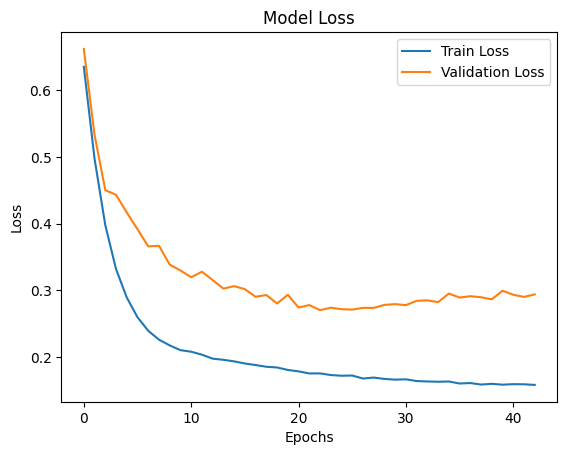

In [193]:
plt.plot(h.history['loss'],label='Train Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

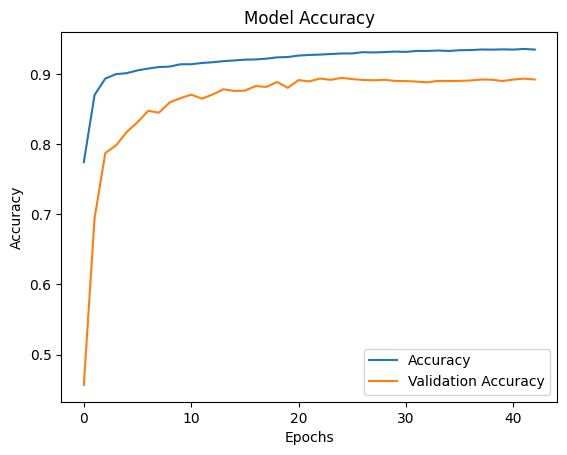

In [194]:
plt.plot(h.history['accuracy'],label='Accuracy')
plt.plot(h.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [287]:
y_pred_probas = model.predict(X_test_scaled)
y_pred = y_pred_probas.copy()

NotFittedError: Estimator needs to be fit before `predict` can be called

In [196]:
y_pred[y_pred <= 0.6] = 0.
y_pred[y_pred > 0.6] = 1.

In [198]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [199]:
model.evaluate(X_test_scaled, y_test)

698/698 [==============================] - 1s 2ms/step - loss: 0.2672 - accuracy: 0.8956


[0.2671751379966736, 0.8956447839736938]

In [200]:
auc = roc_auc_score(y_test, y_pred_probas)
kappa = cohen_kappa_score(y_test, y_pred)
confusion_matrix(y_test, y_pred,normalize='all')

array([[0.29706963, 0.06842011],
       [0.03553186, 0.5989784 ]])

In [201]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_probas)

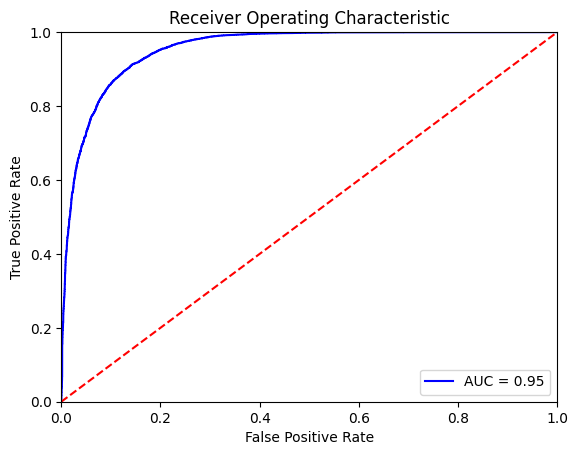

In [202]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


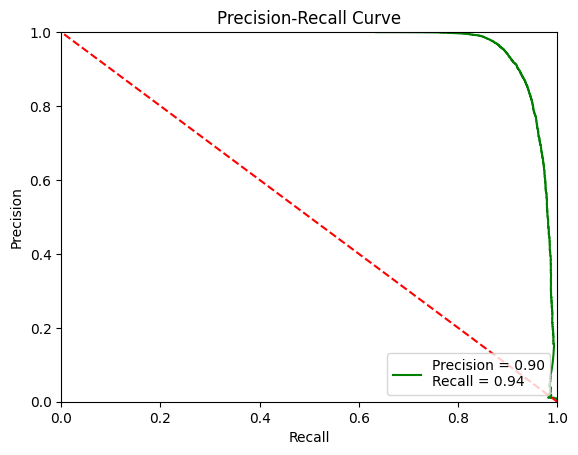

In [203]:
precision, recall,thres = precision_recall_curve(y_test, y_pred_probas)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
plt.title('Precision-Recall Curve')
plt.plot(precision, recall, 'g', label = 'Precision = %0.2f\nRecall = %0.2f' % (prec, rec))
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall');

In [204]:
y_pred = pd.DataFrame(y_pred)
y_test = y_test.reset_index()

In [205]:
predictions = pd.concat([y_test, y_pred], axis=1)
predictions.head()

,index,label,0
0,36509,1.0,1.0
1,61971,1.0,0.0
2,136899,1.0,1.0
3,169676,1.0,1.0
4,136772,1.0,1.0


In [206]:
predictions = predictions.rename(columns={0:'y_pred', 'label':'y_test'})

In [207]:
predictions['y_pred'] = predictions['y_pred'].astype('int')
predictions['y_test'] = predictions['y_test'].astype('int')

In [208]:
indexes = predictions.loc[predictions['y_pred']==1]['index'].values

In [209]:
indexes = predictions.loc[predictions['y_pred']!=predictions['y_test']]['index'].values

In [210]:
predictions

,index,y_test,y_pred
0,36509,1,1
1,61971,1,0
2,136899,1,1
3,169676,1,1
4,136772,1,1
...,...,...,...
22313,12906,1,1
22314,81842,1,1
22315,150234,1,1
22316,20165,1,1


In [211]:
dataset_2.loc[indexes].sort_values('date')#.loc[dataset_2['label']==1]

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,days_since_last_max,days_since_last_min,...,treynor_ratio,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen,sharpe_ratio_next_period,returns_next_period,alfa_next_period,alfa_signal,label
187449,SGRE,2021-01-04,880,-0.005072,-0.017551,-0.721979,0.210634,0.699315,4,1134,...,-0.015996,0.025859,0.247731,0.001257,0.001147,0.177445,0.020454,0.026028,0.0,1.0
187973,SLR,2021-01-04,53,0.040986,-0.045590,-0.338655,0.293682,0.347050,5,68,...,-0.184788,0.028319,0.333083,0.001330,0.046705,0.033991,-0.085201,-0.079294,1.0,1.0
209623,VIS_3,2021-01-04,1160,-0.019335,-0.015757,-0.397681,0.018488,0.290058,144,1515,...,0.001955,0.014178,-0.006008,-0.000168,-0.014094,0.483266,0.016791,0.022173,0.0,0.0
46968,BKIA_1,2021-01-04,1795,0.008211,-0.005658,-0.851932,-0.024886,-0.937831,2492,228,...,-0.000686,0.012487,-0.121577,-0.002716,0.012291,0.331531,-0.000465,0.005266,0.0,0.0
187974,SLR,2021-01-05,54,0.100811,-0.046933,-0.358075,0.334668,0.427720,1,69,...,-0.087235,0.031404,0.355727,0.001170,0.101765,-0.022479,-0.107057,-0.164280,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44856,BBVA,2023-06-06,7552,0.026206,0.037347,-0.934365,-0.050567,2.142191,5964,10568,...,-0.000755,0.016013,-0.082882,0.020889,-0.041705,-2.881897,-0.009674,-0.091947,0.0,0.0
181703,SAN_1,2023-06-06,5495,0.062201,0.047595,-0.766811,-0.098591,0.045586,4894,986,...,-0.001553,0.013130,-0.226362,0.018507,-0.003898,-1.945593,-0.004048,-0.122331,0.0,0.0
174797,SAB,2023-06-07,4832,0.007591,0.035218,-0.938345,-0.002003,-0.623825,5951,951,...,-0.000028,0.018112,-0.017114,0.022597,-0.110744,-2.366340,-0.009365,-0.075852,0.0,0.0
174798,SAB,2023-06-08,4833,-0.023737,0.035503,-0.938345,0.005588,-0.616234,5952,952,...,0.000078,0.018201,0.001441,0.023031,-0.149335,-2.386220,0.003121,-0.063308,0.0,0.0


In [633]:
dataset_results = dataset.iloc[predictions['index']].sort_index()
dataset_results

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,days_since_last_max,days_since_last_min,...,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen,total_alfa_jensen,sharpe_ratio_next_period,returns_next_period,alfa_next_period,label,alfa_signal
12267,ACS,2021-01-04,5772.0,0.018905,-0.001122,-0.925131,0.056353,1.596892,615.0,7630.0,...,0.015735,0.073656,0.001446,0.010740,0.032911,-0.071149,-0.035855,-0.041753,1.0,1.0
12268,ACS,2021-01-05,5773.0,-0.012737,-0.001750,-0.925131,0.075258,1.613051,616.0,7631.0,...,0.015963,0.126516,0.001824,0.015015,0.068915,-0.128239,-0.036950,-0.073530,1.0,1.0
12269,ACS,2021-01-06,5774.0,-0.062881,-0.001323,-0.925131,0.062520,1.634673,617.0,7632.0,...,0.014820,0.038311,0.001678,-0.078582,0.011093,-0.189008,-0.000038,-0.014285,1.0,0.0
12270,ACS,2021-01-07,5775.0,-0.002153,0.000943,-0.925131,-0.000360,1.623560,618.0,7633.0,...,0.013931,-0.070089,0.000217,-0.003656,0.025461,-0.186632,0.007442,0.016766,1.0,0.0
12271,ACS,2021-01-08,5776.0,0.040186,0.001020,-0.925131,-0.002514,1.626080,619.0,7634.0,...,0.013926,-0.075156,0.000164,0.039716,0.028185,-0.172103,-0.003542,-0.002900,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203424,VIS_3,2021-09-20,1343.0,-0.008251,0.001762,-0.397681,-0.013525,0.268172,403.0,1774.0,...,0.009084,0.037924,-0.000566,-0.006615,0.024058,0.000000,0.000000,0.000000,0.0,0.0
203425,VIS_3,2021-09-21,1344.0,-0.023420,0.002580,-0.397681,-0.021776,0.273265,404.0,1775.0,...,0.008990,-0.020333,-0.001007,-0.024415,0.006423,0.000000,0.000000,0.000000,0.0,0.0
203426,VIS_3,2021-09-22,1345.0,0.012406,0.004543,-0.397681,-0.045196,0.262197,405.0,1776.0,...,0.009488,-0.091476,-0.002054,0.013174,0.019329,0.000000,0.000000,0.000000,0.0,1.0
203427,VIS_3,2021-09-23,1346.0,-0.012826,0.003629,-0.397681,-0.032790,0.263908,406.0,1777.0,...,0.009335,-0.075031,-0.001625,-0.013671,0.005097,0.000000,0.000000,0.000000,0.0,0.0


In [192]:
portfolios = dataset.iloc[dataset.iloc[predictions['index']].index].sort_index()[['ticker', 'date', 'label']]
portfolios.set_index('date', inplace=True, drop=True)
portfolios

IndexError: positional indexers are out-of-bounds

In [73]:
portfolios = pd.get_dummies(portfolios, dtype=int).groupby('date').sum()